In [1]:
import pandas as pd
import numpy as np
import sqlite3
import scrapbook as sb
import os

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.dates import date2num, DateFormatter
from pandas.plotting import scatter_matrix

plt.style.use('ggplot')
plt.tight_layout()
plt.rcParams['figure.figsize'] = [20, 20]

%matplotlib inline
%load_ext sql

def vol_ohlc(df, lookback=10):
    o = df.open
    h = df.high
    l = df.low
    c = df.close
    
    k = 0.34 / (1.34 + (lookback+1)/(lookback-1))
    cc = np.log(c/c.shift(1))
    ho = np.log(h/o)
    lo = np.log(l/o)
    co = np.log(c/o)
    oc = np.log(o/c.shift(1))
    oc_sq = oc**2
    cc_sq = cc**2
    rs = ho*(ho-co)+lo*(lo-co)
    close_vol = cc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    open_vol = oc_sq.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    window_rs = rs.rolling(lookback).sum() * (1.0 / (lookback - 1.0))
    result = (open_vol + k * close_vol + (1-k) * window_rs).apply(np.sqrt) * np.sqrt(252)
    result[:lookback-1] = np.nan
    
    return result

def series_plot(data, events=None, ax=None):
    data.plot(ax=ax, legend = True, style = 'g-')
    
    start_of_days = data.between_time('00:00:00', '00:00:00').index.to_list()
    end_of_days = start_of_days[1:] + [data.index[-1]]
    colors = iter(cm.ocean(np.linspace(0, 1, len(start_of_days))))
    
    for x, y in zip(start_of_days, end_of_days):
        color = next(colors)
        ax.axvspan(x, y, color=color, alpha=0.1)

    if events is not None:
        ymin, ymax = ax.get_ylim()
        text_pos = 1
        
        for idx, row in events.loc[data.index[0]:data.index[-1]].iterrows():
            if row.impact == 1:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.2', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.2')    
            elif row.impact == 2:
                text_pos = (text_pos + 1) % 2
                x = idx
                ax.axvline(x, color='0.6', linestyle=':')
                ax.text(x, ymin, row.event, rotation=90, color='0.6')



C:\Users\linru\Anaconda3\envs\hw4\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
token = 'BTC'
from_date = '2021-11-05'
to_date = '2021-11-11'
connection_string = 'sqlite:///data/data.db'
# Parameters
# from_date = "2021-11-29"
# to_date = "2021-12-06"
# token = "AAVE"
# connection_string = "sqlite:///data/data.db"

In [3]:
# Parameters
from_date = "2021-12-06 00:00:00"
to_date = "2021-12-13 00:00:00"
token = "AAVE"
connection_string = "sqlite:///data/data.db"


In [4]:
prices = pd.read_sql(f'''
SELECT 
    * 
FROM ohlc 
WHERE 
    token = '{token}'
    AND ts >= '{from_date}'
    AND ts < '{to_date}'
''', connection_string)
prices['ts'] = pd.to_datetime(prices['ts'])

prices.set_index('ts', inplace=True)

In [5]:
# %sql sqlite:///data/data.db

In [6]:
# %%sql prices << 
# SELECT 
#     * 
# FROM ohlc 
# WHERE 
#     token = '{token}'
#     AND ts >= '{from_date}'
#     AND ts < '{to_date}'

In [7]:
# prices = prices.DataFrame()
# prices['ts'] = pd.to_datetime(prices['ts'])
# prices.set_index('ts', inplace=True)

In [8]:
# compute hourly return
def ret_ohlc(df):
    return df.close.pct_change()

# compute max drawdown
def mdd_ohlc(df):
    roll_max = df.close.cummax()
    dd = df.close/roll_max - 1
    mdd = dd.cummin()
    return mdd

# assign computed stats
prices['return'] = ret_ohlc(prices)
prices['max_drawdown'] = mdd_ohlc(prices)
prices['volatility'] = vol_ohlc(prices)

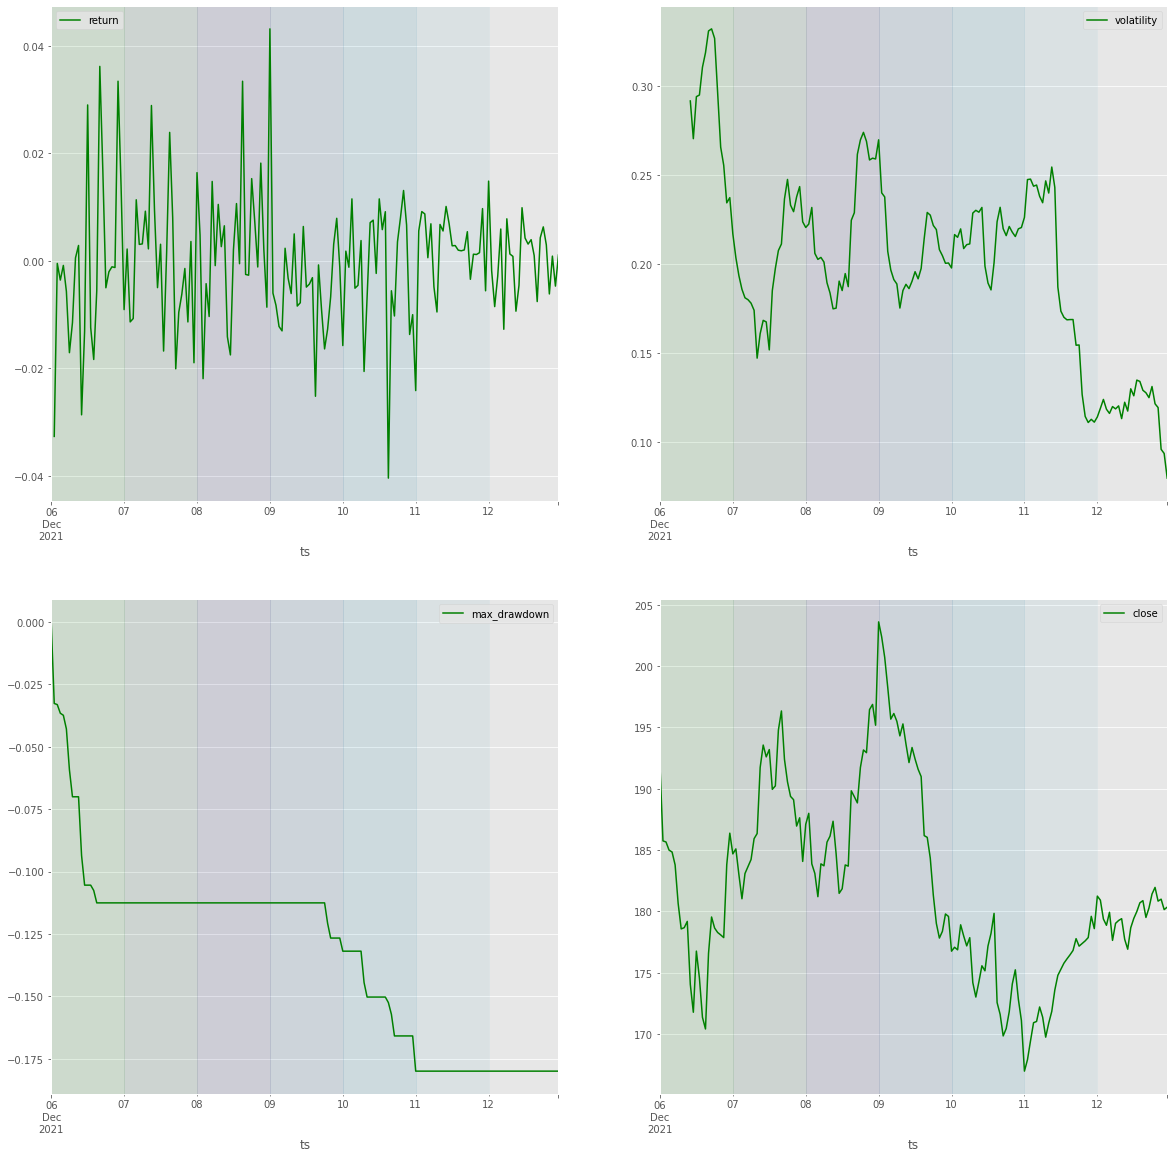

In [9]:
# plotting

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
series_plot(prices['return'], None, ax = ax[0,0]) # plotting hourly return
series_plot(prices['volatility'], None, ax = ax[0,1]) # plotting hourly volatility
series_plot(prices['max_drawdown'], None, ax = ax[1,0]) # plotting max drawdown
series_plot(prices['close'], None, ax = ax[1,1]) # plotting close price



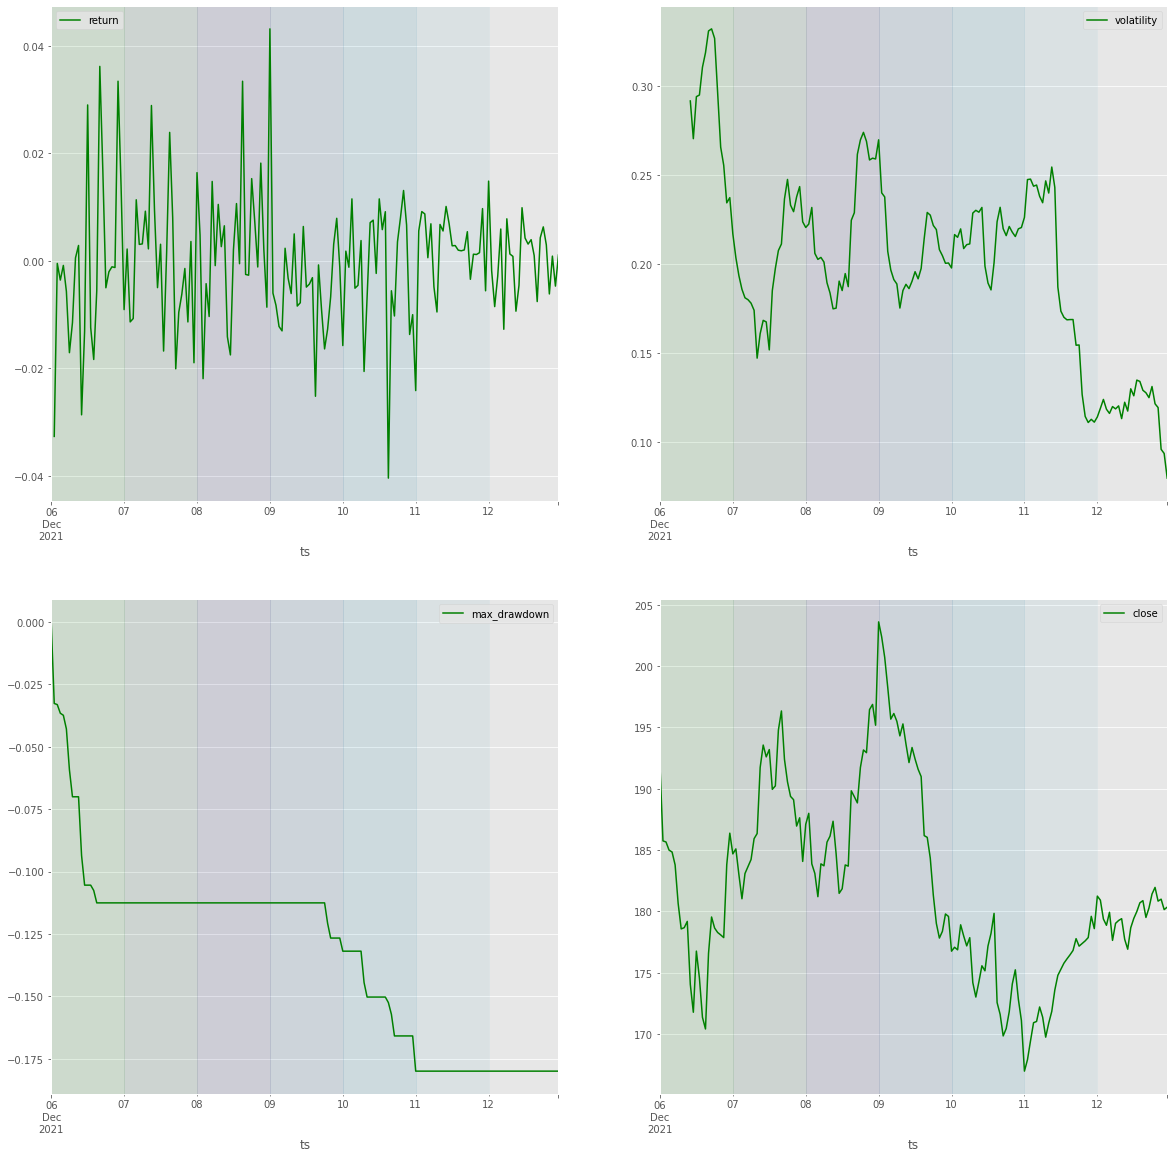

In [10]:
sb.glue('token', token)
sb.glue('from_date', from_date)
sb.glue('to_date', to_date)
sb.glue('prices', prices, encoder='pandas')
sb.glue('summary_plot', fig, encoder='display', display=True)